#                             Solving Problem as a 'Multi-Class' Classification. 

### ~ LIBRARIES

In [3]:
import pandas as pd
import hashlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### ~ DATA FETCH

In [ ]:
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
data = pd.read_csv("//Users//youknowme//Desktop//lmh.csv")
data.drop(data.columns[[26,5,11,14,16,22,23,3,6]],axis=1,inplace=True)
data.head()

### ~ DATA SPLITTING INTO TRAINING SET AND TESTING SET

In [3]:
#TRAIN_TEST_SPLIT inorder to keep the set same as previous & additionally add new instance ratio
#if the dataset got updated.
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

data_with_id = data.reset_index()
train_set , test_set = split_train_test_by_id(data_with_id, 0.2, "index")
train_set = train_set.drop(train_set.columns[0],axis = 1)
test_set = test_set.drop(test_set.columns[0],axis = 1)

### ~ DATA CHECK (FOR NULL VALUES AND UNBALANCED DATASET)


In [4]:
removed_na_df = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
temp_data =(len(removed_na_df)/len(data))
str(round(temp_data*100)) + ' '+ 'Percent'

'14.0 Percent'

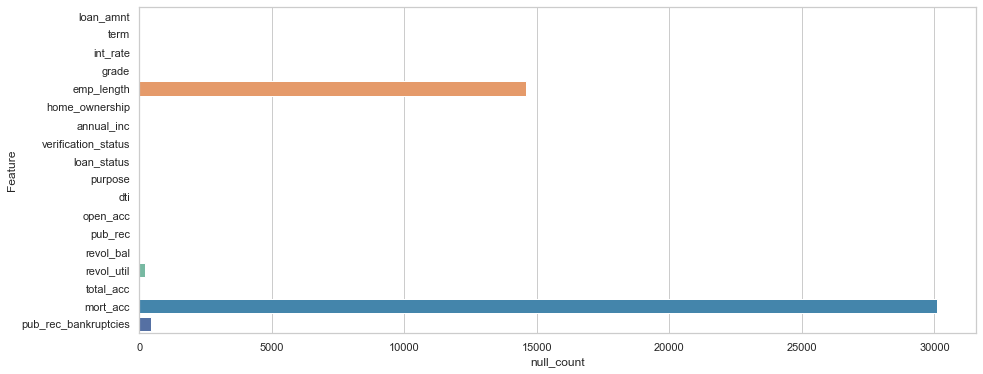

In [5]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
nval = pd.DataFrame(train_set.isnull().sum()).reset_index()
nval.columns = ['Feature','null_count']
sns.barplot(x='null_count',y='Feature', data=nval, palette='Spectral')

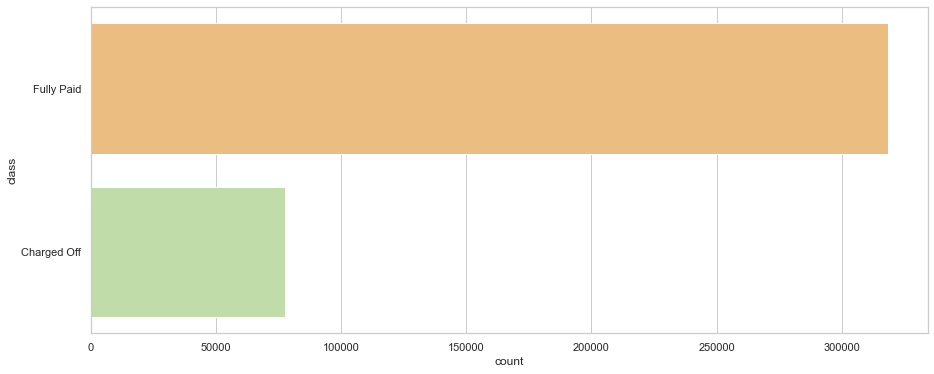

In [28]:
f, ax = plt.subplots(figsize=(15, 6))
c = pd.DataFrame(data.loan_status.value_counts()).reset_index()
c.columns = ['class','count']
sns.barplot(x='count',y='class', data=c, palette='Spectral')

### ~ DATA VISUALIZATION

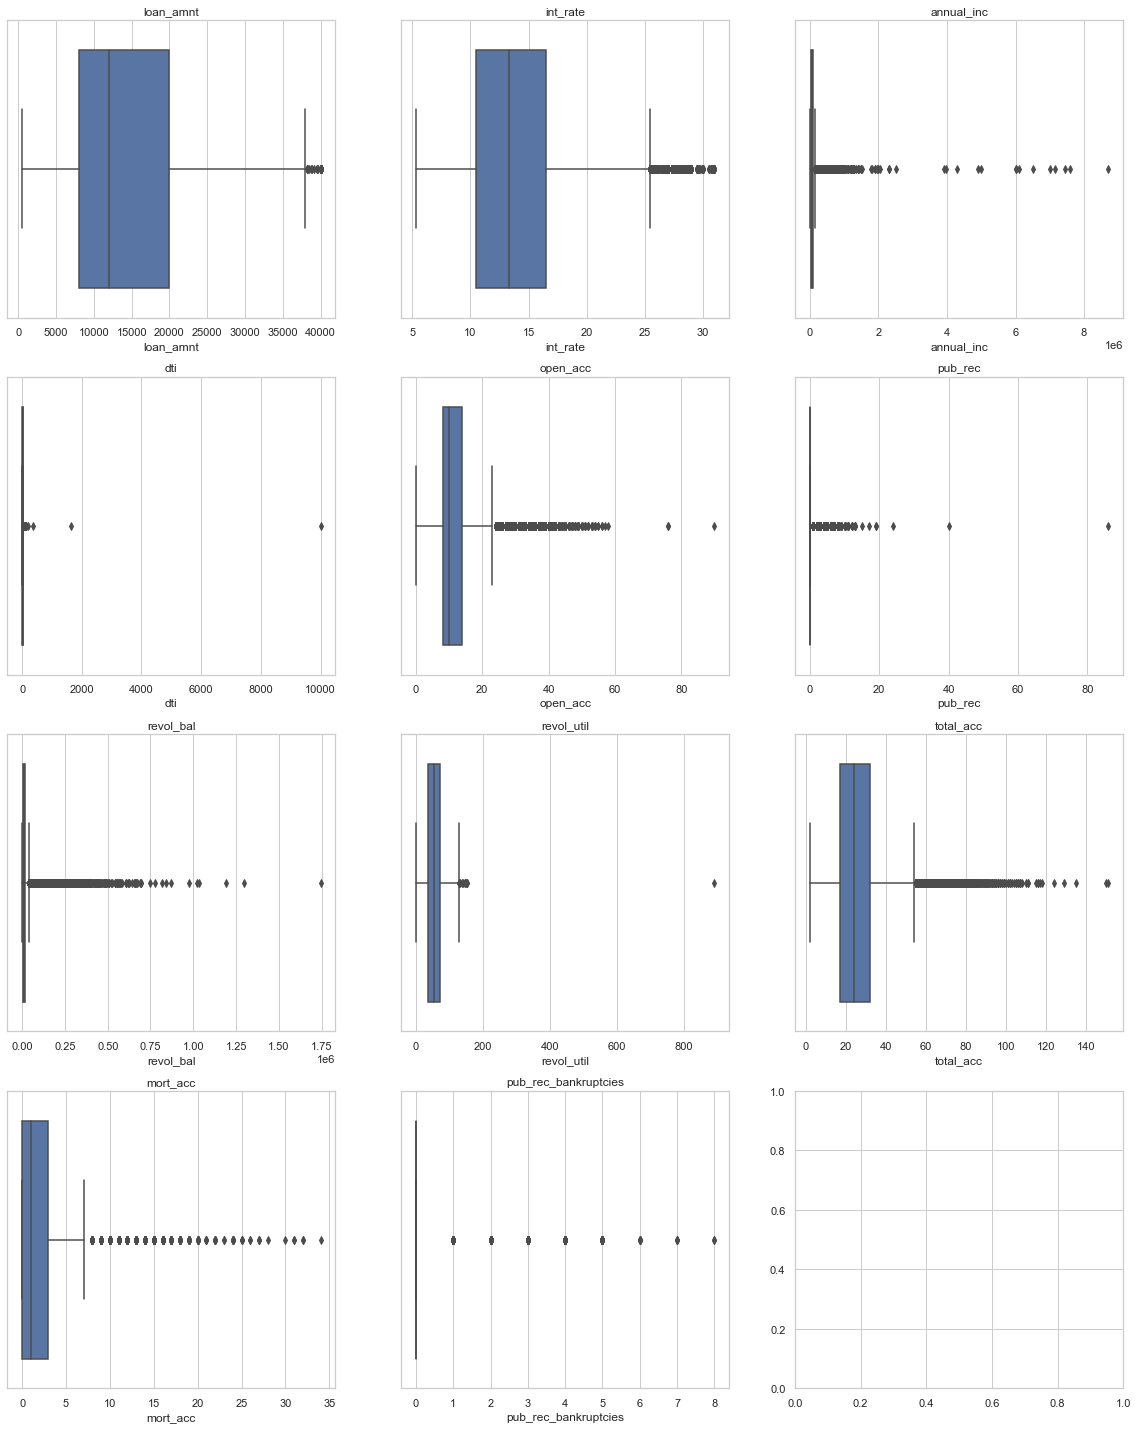

In [7]:
# BOX PLOT: OUTLIER CHECK
def multiple_box(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_numeric = data.select_dtypes(include=numerics)
    x= len(df_numeric.columns)
    row = np.int16(np.ceil(x/3))
    fig, axs = plt.subplots(row,3,figsize = (20,10))
    fig.subplots_adjust(bottom=0.1, right=0.9, top=2.0)
    plot_count = 0
    for i in range(0,row):
        for j in range(0,3):
            if (i+1)*(j+1) <= x:
                l = sns.boxplot(x = df_numeric.iloc[:,plot_count],ax=axs[i,j])
                l.title.set_text(df_numeric.columns[plot_count])
                plot_count = plot_count + 1
            else:
                break
                
multiple_box(data)
            

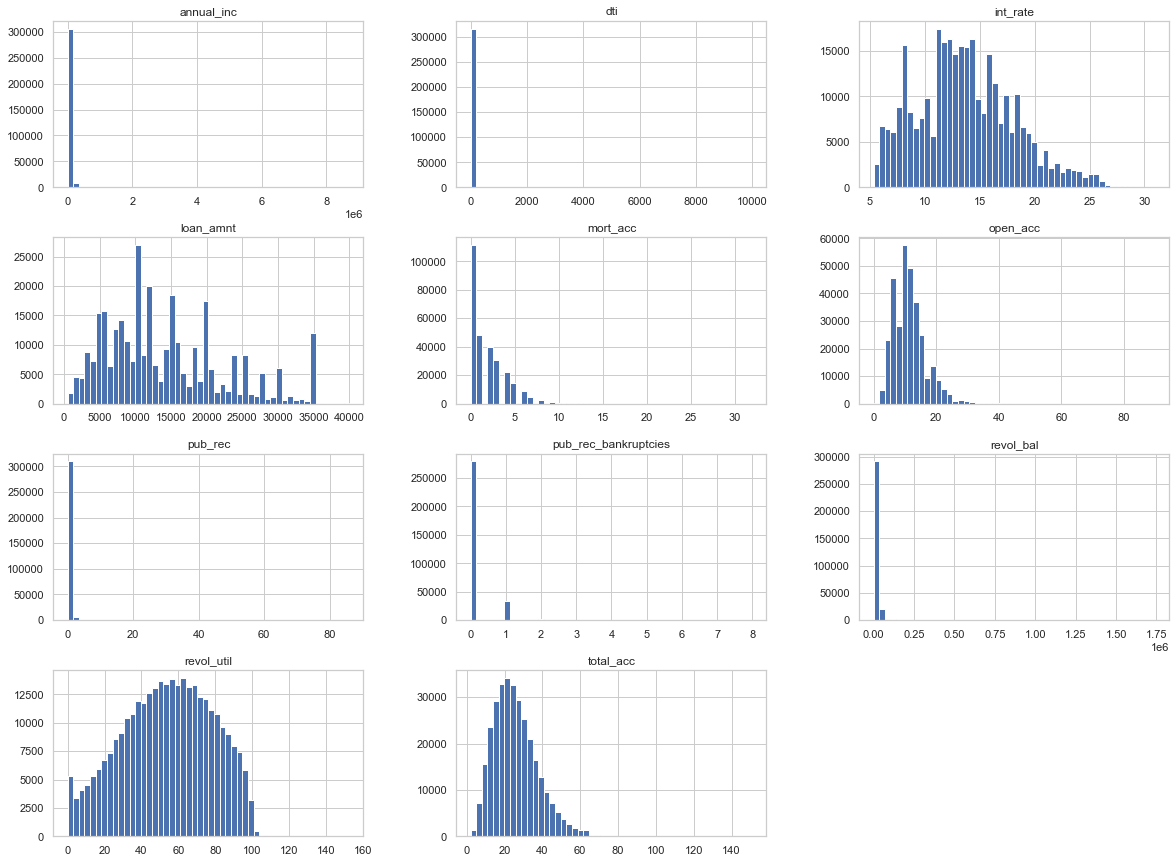

In [8]:
#Data Visualization in order to find new information and birds eye on the pattern that data might follow.
#visual_2 : Distribution check(which column needs to be transform)
import matplotlib.pyplot as plt
train_set.hist(bins=50, figsize=(20,15))
plt.show()

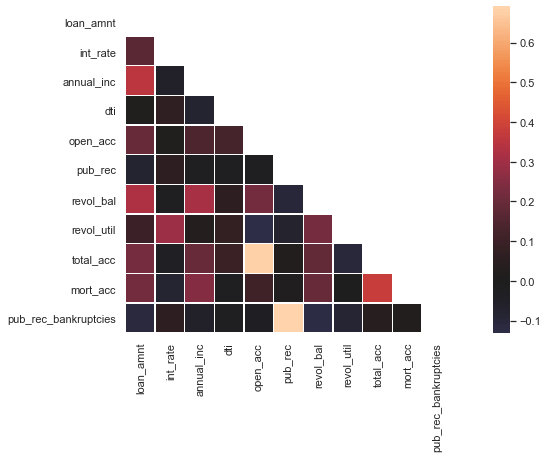

In [9]:
57

,loan_amnt,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_status,,,,,,,,,,,
Charged Off,15112.123685,15.882462,67421.636354,19.680680,11.596691,0.200136,15283.611525,57.807987,25.005947,1.500957,0.129283
Fully Paid,13862.253583,13.096069,75781.456103,16.824255,11.236485,0.172954,15940.679324,52.781229,25.508076,1.895037,0.119867


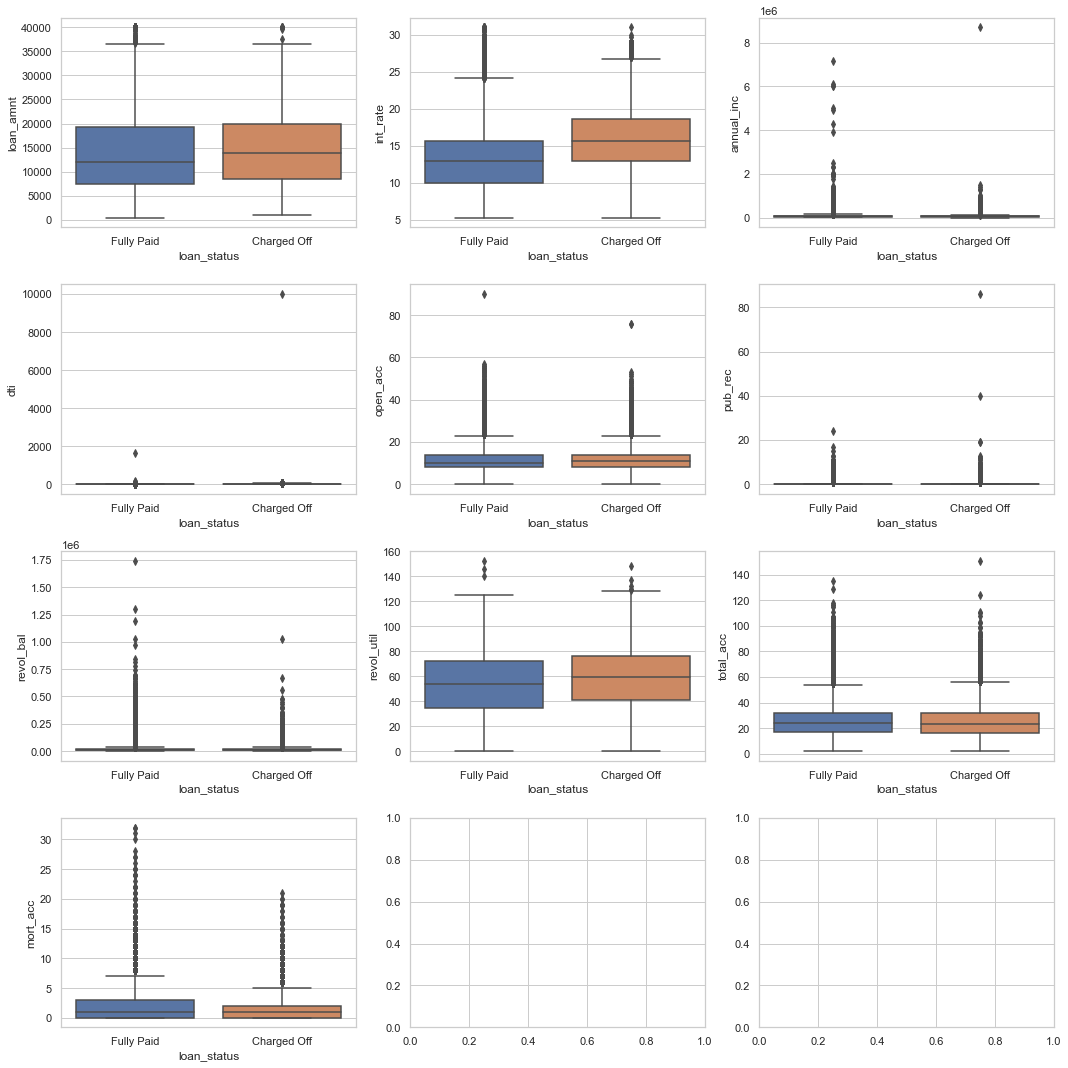

In [10]:
# Bi_Variate Analysis : How each independent feature influencing the target class & how seperable two classes are-
# - in order to classify the data point more clearly. 

display(train_set.groupby('loan_status').mean())
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = train_set.select_dtypes(include=numerics)
x = np.int16(np.ceil(len(df_numeric.columns)/3))
fig, axes = plt.subplots(x, 3, figsize = (15,15))
axes = axes.flatten()
target = train_set[['loan_status']]
df = pd.concat([df_numeric,target],axis = 1,ignore_index = True)
for i in range(0,len(df_numeric.columns)-1):
    sns.boxplot(x="loan_status", y=df_numeric.iloc[:,i], data=train_set, orient='v', ax=axes[i])

plt.tight_layout()
plt.show()

### ~ DATA CLEANING

In [4]:
#REMOVING OUTLIERS
Q1 = train_set.quantile(0.25)
Q3 = train_set.quantile(0.75)
IQR = Q3 - Q1
display(train_set.shape)
train_set= train_set[~((train_set < (Q1 - 1.5 * IQR)) |(train_set > (Q3 + 1.5 * IQR))).any(axis=1)]
display(train_set.shape)

(315772, 18)

(231701, 18)

In [5]:
#FILLING MISSING VALUES WITH 'MEDIAN'

def fill_na(data):
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = data.select_dtypes(include=numerics)
    catdf = data.select_dtypes(exclude=numerics).reset_index()
    catdf = catdf.drop(catdf.columns[0],axis=1)
    imputer.fit(newdf)
    newdf_ = pd.DataFrame(imputer.transform(newdf))
    newdf_.columns = newdf.columns
    data = pd.concat([newdf_,catdf],axis = 1)
    #data.dropna(axis=0,inplace=True)
    return data

train_set = fill_na(train_set)
    

### ~ SPLITTING DEPENDENT AND INDEPENDENT VARIABLES 

In [6]:
#Split 2 -- independent columns & target column

train_set.dropna(axis=0,inplace=True)
test_set.dropna(axis=0,inplace=True)

x_train = train_set.drop(train_set[['loan_status']],axis=1)
y_train = train_set[['loan_status']]

x_test = test_set.drop(test_set[['loan_status']],axis=1)
y_test = test_set[['loan_status']]

 ### ~ DATA PREPROCESSING

In [7]:
#CHANGING CATEGORIAL VALUE TO NUMERICAL USING 'One hot encoding'

def one_hot_chick(data):
    from sklearn import preprocessing
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    encoder = LabelEncoder()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf_categorical = data.select_dtypes(exclude=numerics)
    newdf_numeric = data.select_dtypes(include=numerics).reset_index()
    newdf_numeric = newdf_numeric.drop(newdf_numeric.columns[0],axis=1)
    newdf_categorical= newdf_categorical.apply(LabelEncoder().fit_transform)
    var = newdf_categorical.columns
    encode_hot = OneHotEncoder()
    encode_hot.fit(newdf_categorical)
    encode_hot.get_feature_names(input_features=var)
    onehotlabels = encode_hot.transform(newdf_categorical)
    category_onehot = pd.DataFrame(onehotlabels.toarray())
    category_onehot.columns = encode_hot.get_feature_names(input_features=var)
    result_data = pd.concat([newdf_numeric,category_onehot],axis=1)
    result_data = result_data.drop(result_data.columns[0],axis=1)
    return result_data

x_train = one_hot_chick(x_train)
x_test = one_hot_chick(x_test)

In [8]:
display(x_train.head())

,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_0,term_1,grade_0,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,emp_length_0,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,emp_length_10,home_ownership_0,home_ownership_1,home_ownership_2,home_ownership_3,home_ownership_4,home_ownership_5,verification_status_0,verification_status_1,verification_status_2,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12,purpose_13
0,11.44,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,11.99,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.49,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.49,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.32,125000.0,1.36,8.0,0.0,4178.0,4.9,25.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# SCALING VALUE: STANDARDIZATION

def scale_standard(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    scaled_data.columns = data.columns
    return scaled_data

x_train = scale_standard(x_train)
x_test = scale_standard (x_test)

In [10]:
display(x_train.head())

,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,term_0,term_1,grade_0,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,emp_length_0,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,emp_length_10,home_ownership_0,home_ownership_1,home_ownership_2,home_ownership_3,home_ownership_4,home_ownership_5,verification_status_0,verification_status_1,verification_status_2,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12,purpose_13
0,-0.461907,1.776922,1.124001,1.235674,0.0,2.598460,-0.514598,0.150623,-0.848286,0.0,0.546807,-0.546807,-0.458386,1.531272,-0.599355,-0.432418,-0.288065,-0.16811,-0.038366,-0.280253,1.485835,-0.33058,-0.308502,-0.264933,-0.280515,-0.244683,-0.242544,-0.230112,-0.205308,-0.311969,-0.003003,-0.946403,-0.009731,-0.018876,-0.315039,1.135583,1.333816,-0.690554,-0.681706,-0.113256,-0.514396,-1.213702,-0.027777,-0.237787,-0.073009,-0.154485,-0.103349,-0.087258,-0.23956,-0.029511,-0.119969,12.453404,-0.075646
1,-0.335458,-0.035731,0.598414,1.467384,0.0,0.788441,-0.045064,0.346555,0.913867,0.0,0.546807,-0.546807,-0.458386,1.531272,-0.599355,-0.432418,-0.288065,-0.16811,-0.038366,-0.280253,-0.673022,-0.33058,-0.308502,3.774537,-0.280515,-0.244683,-0.242544,-0.230112,-0.205308,-0.311969,-0.003003,1.056633,-0.009731,-0.018876,-0.315039,-0.880605,1.333816,-0.690554,-0.681706,-0.113256,-0.514396,0.823925,-0.027777,-0.237787,-0.073009,-0.154485,-0.103349,-0.087258,-0.23956,-0.029511,-0.119969,-0.080299,-0.075646
2,-0.680319,-0.800635,-0.563145,0.540543,0.0,-0.119355,1.543187,0.248589,-0.848286,0.0,0.546807,-0.546807,-0.458386,1.531272,-0.599355,-0.432418,-0.288065,-0.16811,-0.038366,-0.280253,-0.673022,-0.33058,-0.308502,-0.264933,-0.280515,-0.244683,-0.242544,-0.230112,-0.205308,3.205450,-0.003003,-0.946403,-0.009731,-0.018876,-0.315039,1.135583,-0.749729,1.448113,-0.681706,-0.113256,1.944028,-1.213702,-0.027777,-0.237787,-0.073009,-0.154485,-0.103349,-0.087258,-0.23956,-0.029511,-0.119969,-0.080299,-0.075646
3,-1.599950,-0.419176,-1.841361,-1.081429,0.0,-0.845569,-1.343429,-1.024967,-0.848286,0.0,0.546807,-0.546807,2.181569,-0.653052,-0.599355,-0.432418,-0.288065,-0.16811,-0.038366,-0.280253,-0.673022,-0.33058,-0.308502,-0.264933,-0.280515,4.086922,-0.242544,-0.230112,-0.205308,-0.311969,-0.003003,-0.946403,-0.009731,-0.018876,-0.315039,1.135583,1.333816,-0.690554,-0.681706,-0.113256,1.944028,-1.213702,-0.027777,-0.237787,-0.073009,-0.154485,-0.103349,-0.087258,-0.23956,-0.029511,-0.119969,-0.080299,-0.075646
4,-1.868942,2.055791,-1.996904,-0.618008,0.0,-0.989809,-2.021191,0.150623,0.913867,0.0,0.546807,-0.546807,2.181569,-0.653052,-0.599355,-0.432418,-0.288065,-0.16811,-0.038366,-0.280253,-0.673022,3.02499,-0.308502,-0.264933,-0.280515,-0.244683,-0.242544,-0.230112,-0.205308,-0.311969,-0.003003,1.056633,-0.009731,-0.018876,-0.315039,-0.880605,-0.749729,1.448113,-0.681706,-0.113256,-0.514396,-1.213702,-0.027777,4.205444,-0.073009,-0.154485,-0.103349,-0.087258,-0.23956,-0.029511,-0.119969,-0.080299,-0.075646


### ~ SELECTING CLASSIFIER : (TRAINING MODEL)
     RANDOM FOREST

In [41]:
# MODEL - CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [42]:
from sklearn.model_selection import cross_val_score
y_train = (y_train == 'Charged Off')
cross_val_score(forest_clf, x_train, y_train.values.ravel(), cv=4, scoring="accuracy")

array([0.80874662, 0.80885482, 0.80853021, 0.81000902])

 ### ~ Error Analysis

In [43]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(forest_clf, x_train, y_train.values.ravel(), cv=3) 

In [21]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[  3277,  38931],
       [  3304, 176288]])

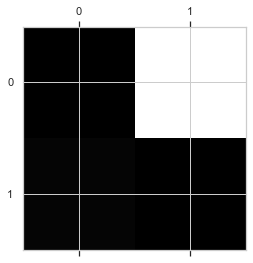

In [22]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

 Charged Off       0.50      0.08      0.13     42208
  Fully Paid       0.82      0.98      0.89    179592

    accuracy                           0.81    221800
   macro avg       0.66      0.53      0.51    221800
weighted avg       0.76      0.81      0.75    221800



In [24]:
# -- ROC CURVE : TPR and FPR  visualisation analysis 
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train.values.ravel(), cv=3,method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

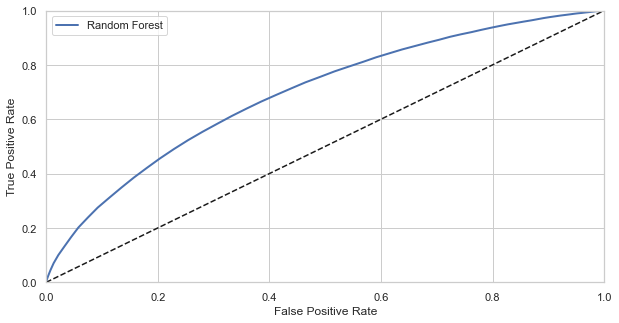

In [25]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize = (10,5))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_train_bool = (y_train=="Fully Paid")
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_bool,y_scores_forest )
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()

### ~ DEPLOYING MODEL ( RANDOM FOREST )

In [ ]:
# ---- train set check
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, x_test, y_test.values.ravel(), cv=4, scoring="accuracy")

In [ ]:
from sklearn.model_selection import cross_val_predict
y_test_pred = cross_val_predict(forest_clf, x_test, y_test.values.ravel(), cv=3) 
from sklearn.metrics import confusion_matrix
conf_mx_test = confusion_matrix(y_test, y_test_pred)
conf_mx_test

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx_test = conf_mx_test / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx_test, cmap=plt.cm.gray)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

    ~ Support Vector Machine  

In [ ]:
#Import svm model
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(x_train, y_train.values.ravel())
#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))